In [58]:
"""Sandbox module."""
import matplotlib.pyplot as plt
import numpy as np
import warnings

from fda_funcs import (
    compute_moments,
    compute_principal_components,
    compute_fpc_scores,
    mode_of_variation
)
from misc import (
    cdf_from_density,
    density_from_qd,
    l2_norm,
    norm_pdf,
    norm_cdf,
    quantile_from_cdf,
    riemann_sum_arrays,
    trunc_norm_pdf,
)
from scipy.interpolate import CubicSpline
from scipy.stats import norm, truncnorm

%matplotlib inline

In [59]:
# Make the warning always appear
warnings.filterwarnings("always")

$\int_0^1 f(t)dt$  wird dann durch die Riemann Summe $1/m \sum_{j=1}^m f(s_j)$ ersetzt ($s_j$  - Gridpunkte, $m$ -  Anzahl der Gridpunkte).

# Functional Data Analysis

Ideas for simulation
- Uni- vs. Multivariate case
- Simulate different normal distributions
- Vary parameters of (generalized) Beta distribution, so principal components can be interpreted as varying parameters

$X(t) = \sum_{k=1}^n η_k φ_k(t)$


## Transformation Method Paper (Petersen & Müller 2016)

In [124]:
# 1. Generate synthetic functional data
n = 200
gridnum = 1000
truncation_point = 3
delta=1e-10

grid_densities = np.linspace(
    start=-truncation_point,
    stop=truncation_point,
    num=gridnum,
)
grid_quantiles = np.linspace(start=delta, stop=1-delta, num=gridnum)
range_support = grid_densities[-1] - grid_densities[0]

# Draw different sigmas
log_sigmas = np.random.default_rng(seed=28071995).uniform(-1.5, 1.5, n)
mus = np.zeros(n)
sigmas = np.exp(log_sigmas)

In [61]:
# Calculate discretized distributions, with different methods, to compare performance

# Calculate densities
a, b = (-truncation_point - mus) / sigmas, (truncation_point - mus) / sigmas
densities_discretized = norm_pdf(grid_densities[:,np.newaxis], mus, sigmas).transpose()
densities_discretized2 = truncnorm.pdf(
    x=grid_densities[:, np.newaxis],
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
densities_discretized3 = trunc_norm_pdf(
    grid_densities[:, np.newaxis],
    mus,
    sigmas,
    -truncation_point,
    truncation_point,
).transpose()

# Calculate distribution functions
cdfs_discretized = cdf_from_density(
    grid_densities,
    densities_discretized,
    axis=1,
)
cdfs_discretized2 = cdf_from_density(
    grid_densities,
    densities_discretized2,
    axis=1,
)
cdfs_discretized3 = cdf_from_density(
    grid_densities,
    densities_discretized3,
    axis=1,
)

# Calculate quantiles
quantiles_discretized = norm.ppf(grid_quantiles[:, np.newaxis], mus, sigmas).transpose()
quantiles_discretized2 = truncnorm.ppf(
    q=grid_quantiles[:, np.newaxis],
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
quantiles_discretized3 = quantile_from_cdf(
    grid_densities[:, np.newaxis].transpose(),
    cdfs_discretized3,
    grid_quantiles,
)

# Calculate quantile densities
quantile_densities_discretized = np.reciprocal(
    norm_pdf(quantiles_discretized.transpose(), mus, sigmas),
).transpose()
quantile_densities_discretized2 = np.reciprocal(
    truncnorm.pdf(quantiles_discretized2.transpose(), a=a, b=b, loc=mus, scale=sigmas),
).transpose()
quantile_densities_discretized3 = np.reciprocal(
    trunc_norm_pdf(
        quantiles_discretized3.transpose(),
        mus,
        sigmas,
        -truncation_point,
        truncation_point,
    ),
).transpose()

# Normalize quantile densities
quantile_densities_discretized = (
    quantile_densities_discretized
    * range_support
    / riemann_sum_arrays(grid_quantiles, quantile_densities_discretized, axis = 1)[:, np.newaxis]
)

quantile_densities_discretized2 = (
    quantile_densities_discretized2
    * range_support
    / riemann_sum_arrays(grid_quantiles, quantile_densities_discretized2, axis = 1)[:, np.newaxis]
)

quantile_densities_discretized3 = (
    quantile_densities_discretized3
    * range_support
    / riemann_sum_arrays(grid_quantiles, quantile_densities_discretized3, axis = 1)[:, np.newaxis]
)

c:\Coding\frechet_fda\src\frechet_fda\misc.py:140: UserWarning: Not all provided densities integrate to 1!
 Max case of deviation is: 0.4872626704889901 
 In position: 40 
 Performing normalization...
  warnings.warn(


In [64]:
### Check whether my function differs from scipy func on first generated density sample
eps = 1e-2
(
    (abs(densities_discretized[0] - densities_discretized2[0]) > eps).sum(),
    (abs(cdfs_discretized[0] - cdfs_discretized2[0]) > eps).sum(),
    (abs(quantiles_discretized[0] - quantiles_discretized2[0]) > eps).sum(),
    (
        abs(quantile_densities_discretized[0] - quantile_densities_discretized2[0])
        > eps
    ).sum(),
    (abs(densities_discretized2[0] - densities_discretized3[0]) > eps).sum(),
    (abs(cdfs_discretized2[0] - cdfs_discretized3[0]) > eps).sum(),
    (abs(quantiles_discretized2[0] - quantiles_discretized3[0]) > eps).sum(),
    (
        abs(quantile_densities_discretized2[0] - quantile_densities_discretized3[0])
        > eps
    ).sum(),
)

(0, 0, 0, 0, 0, 0, 0, 420)

### Check how fast the different implementations are.

1. My normal distribution functions
2. Scipy's Truncated normals
3. My truncated normals

(For quantiles always used scipy's implementation of ppf.)

In [65]:
%%timeit
densities_discretized = norm_pdf(grid_densities[:,np.newaxis], mus, sigmas).transpose()
quantiles_discretized = norm.ppf(grid_quantiles[:,np.newaxis], mus, sigmas).transpose()
quantile_densities_discretized = np.reciprocal(
    norm_pdf(quantiles_discretized.transpose(), mus, sigmas),
).transpose()

42.3 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [66]:
%%timeit
densities_discretized2 = truncnorm.pdf(
    x=grid_densities[:,np.newaxis],
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
quantiles_discretized2 = truncnorm.ppf(
    q=grid_quantiles[:,np.newaxis],
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
quantile_densities_discretized2 = np.reciprocal(
    truncnorm.pdf(quantiles_discretized2.transpose(), a=a, b=b, loc=mus, scale=sigmas),
).transpose()

207 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
%%timeit
densities_discretized3 = trunc_norm_pdf(grid_densities[:,np.newaxis], mus, sigmas, a, b).transpose()
quantiles_discretized3 = quantile_from_cdf(
    grid_densities[:,np.newaxis].transpose(),
    cdfs_discretized,
    grid_quantiles,
)
quantile_densities_discretized3 = np.reciprocal(
    trunc_norm_pdf(
        quantiles_discretized3.transpose(),
        mus,
        sigmas,
        -truncation_point,
        truncation_point,
    ),
).transpose()

54.1 ms ± 5.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 3rd approach faster than scipys
Less accurate with quantiles though. Gets better with higher grid size, but wont do more
than 1000 for computational cost

### Use implementation 3, faster than scipy but still correct

In [68]:
ds_discretized = densities_discretized3
cs_discretized = cdfs_discretized3
qs_discretized = quantiles_discretized3
qds_discretized = quantile_densities_discretized3

## Compare my discretized cdf to analytical cdf from scipy, to see whether S shape is there

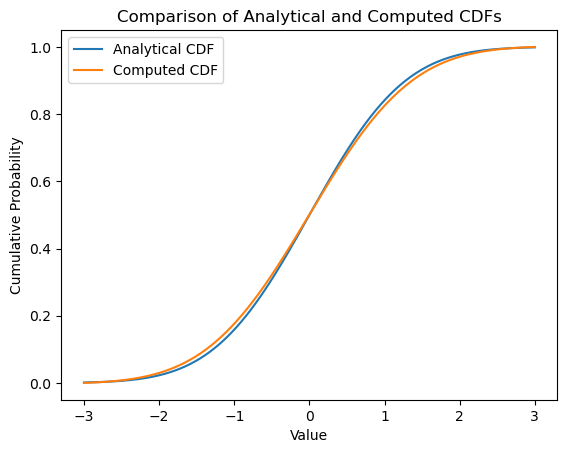

In [69]:
# Analytical CDF for standard normal distribution
analytical_cdf = norm.cdf(grid_densities)

# Plot
plt.plot(grid_densities, analytical_cdf, label="Analytical CDF")
plt.plot(
    grid_densities,
    cs_discretized[14],
    label="Computed CDF",
)  # Adjust index as needed
plt.legend()
plt.xlabel("Value")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Analytical and Computed CDFs")
plt.show()

## Perform FPCA

In [70]:
# Compute moments to work with in FPCA
mean_function, centered_densities, cov_matrix = compute_moments(ds_discretized)

In [71]:
# Compute the eigenfunctions (principal components) of the covariance matrix
eigenvalues, eigenfunctions = compute_principal_components(cov_matrix, grid_densities)

In [72]:
# Compute FPC scores / factor loadings
fpc_scores = compute_fpc_scores(centered_densities, eigenfunctions, grid_densities)

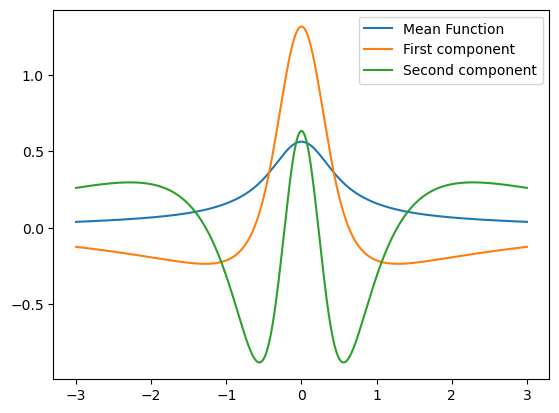

In [73]:
# Plot the mean function and the first two eigenfunctions
fig, ax = plt.subplots()
ax.plot(grid_densities, mean_function, label="Mean Function")
ax.plot(grid_densities, eigenfunctions[:, 0], label="First component")
ax.plot(grid_densities, eigenfunctions[:, 1], label="Second component")
plt.legend()
plt.show()

## More reproducing of Petersen & Müller (2016)

In [74]:
# Compute first two modes of variation
first_two_modes = mode_of_variation(
    mean_function,
    eigenvalues[:2],
    eigenfunctions[:, :2],
    1
)

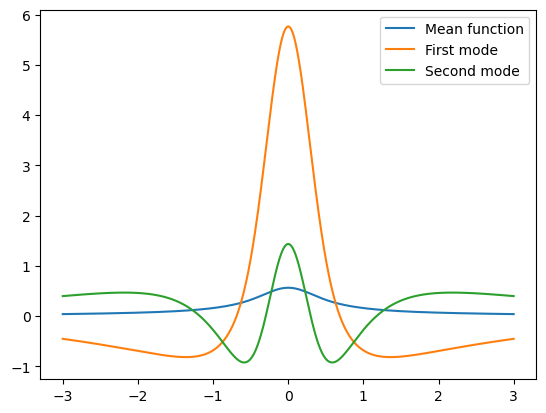

In [75]:
fig, ax = plt.subplots()
ax.plot(grid_densities, mean_function, label="Mean function")
ax.plot(grid_densities, first_two_modes[:, 0], label="First mode")
ax.plot(grid_densities, first_two_modes[:, 1], label="Second mode")
plt.legend()
plt.show()

## Fréchet mean estimation

In [77]:
from scipy.interpolate import CubicSpline

In [127]:
def wasserstein_frechet_mean(qds_discretized, grid, qdsup=None):
    """Compute Wasserstein-Fréchet mean from sample."""
    if qdsup is None:
        qdsup = np.linspace(0, 1, len(qd))
    mean_qdf = np.mean(qds_discretized, axis=0)
    mean_qdf = (
        mean_qdf
        * (grid[-1] - grid[0])
        / riemann_sum_arrays(qdsup, array=mean_qdf, axis=0, cumsum=False)
    )
    return qd2dens(mean_qdf, qdsup=qdsup, dsup=grid, useSplines=True)
    #density_from_qd(mean_qdf, start_quantile, grid, qdsup)

In [128]:
def qd2dens(qd, qdsup=None, dsup=None, useSplines=True):
    # Validate input

    if not np.allclose([np.min(qdsup), np.max(qdsup)], [0, 1], atol=1e-5):
        print([np.min(qdsup), np.max(qdsup)])
        raise ValueError("Please check the support of the QD domain's boundaries.")
    
    integral_qd = riemann_sum_arrays(qdsup, array=qd, axis=0, cumsum=False)
    if not np.isclose(integral_qd, np.ptp(dsup), atol=1e-5):
        print(integral_qd, np.ptp(dsup))
        raise ValueError("Quantile Density should integrate to the range of dsup.")
    
    if useSplines:
        # Use cubic spline interpolation
        qd_spline = CubicSpline(qdsup, qd, bc_type='natural')
        qd_spline_vals = qd_spline(grid_quantiles)
        dtemp = [dsup[0]]
        dtemp = dsup[0]+ riemann_sum_arrays(qdsup, array=qd, axis=0, cumsum=False)
        for i in range(1, len(qdsup)):
            integral_val, _ = quad(qd_spline, qdsup[i-1], qdsup[i])
            dtemp.append(dtemp[-1] + integral_val)
    else:
        # Use cumulative trapezoidal rule
        dtemp = dsup[0] + cumtrapz(qd, qdsup, initial=0)
    
    # Calculate density
    dens_temp = 1 / qd
    dtemp, idx_unique = np.unique(dtemp, return_index=True)
    dens_temp = dens_temp[idx_unique]
    dens_interp = interp1d(dtemp, dens_temp, kind='linear', fill_value="extrapolate")
    dens = dens_interp(dsup)
    
    # Normalize the density
    dens = dens / np.trapz(dens, dsup)
    
    return dens, dtemp

In [136]:
CubicSpline(grid_quantiles, qds_discretized[0], bc_type='natural')(grid_quantiles)

array([47.49076987, 44.70681486, 40.88631028, 38.55543919, 36.38234392,
       34.35523955, 32.46329312, 30.69654176, 29.04581822, 27.50268311,
       26.76900766, 25.37287328, 24.70869577, 23.44407648, 22.84211246,
       22.25941379, 21.14908595, 20.62015968, 20.10790234, 19.61172668,
       19.13106813, 18.66538387, 18.21415195, 17.35305639, 16.94224555,
       16.54399107, 16.54399107, 16.15786307, 15.78344792, 15.42034751,
       15.0681787 , 14.72657266, 14.39517432, 14.07364182, 13.76164596,
       13.76164596, 13.45886972, 13.16500775, 12.87976593, 12.87976593,
       12.60286091, 12.33401969, 12.07297922, 12.07297922, 11.819486  ,
       11.57329569, 11.57329569, 11.33417279, 11.10189028, 11.10189028,
       10.87622927, 10.65697872, 10.65697872, 10.44393511, 10.23690215,
       10.23690215, 10.03569055, 10.03569055,  9.84011767,  9.84011767,
        9.65000734,  9.46518958,  9.46518958,  9.28550038,  9.28550038,
        9.11078144,  9.11078144,  8.94088   ,  8.94088   ,  8.77

In [129]:
def density_from_qd(qd, start_quantile, dsup, qdsup=None):
    """Compute density from a quantile density function.

    'Inspired' from qd2dens in fdadensity package in R.

    """
    if qdsup is None:
        qdsup = np.linspace(0.2, 1, len(qd))
    quantile_oplus = start_quantile  + riemann_sum_arrays(
        support_grid=qdsup, array=qd, axis=0, cumsum=True
    )

    dens_temp = 1 / qd
    ind = np.unique(quantile_oplus, return_index=True)[1]
    quantile_oplus = np.atleast_1d(quantile_oplus)[ind]
    dens_temp = dens_temp[~ind]
    dens = np.interp(dsup, quantile_oplus, dens_temp)
    dens /= riemann_sum_arrays(dsup, dens, axis=0, cumsum=False)

    return dens, quantile_oplus

In [130]:
f_oplus, quantile_oplus = wasserstein_frechet_mean(
    qds_discretized,
    grid_densities,
    grid_quantiles
)
F_oplus = cdf_from_density(
    grid_densities,
    f_oplus,
    axis=0,
)
F_oplus[-1]

1.0

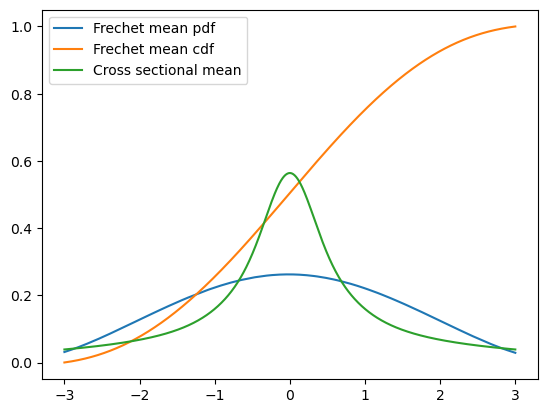

In [131]:
fig, ax = plt.subplots()
ax.plot(grid_densities, f_oplus, label="Frechet mean pdf")
ax.plot(grid_densities, F_oplus, label="Frechet mean cdf")
ax.plot(grid_densities, mean_function, label="Cross sectional mean")
plt.legend()
plt.show()

In [ ]:
mean_qdf = np.mean(qds_discretized, axis=0)
mean_qf = np.mean(qs_discretized, axis=0)

In [ ]:
lim = 999
mean_qdf[lim], riemann_sum_arrays(grid_quantiles[:lim], array=mean_qdf[:lim], axis=0, cumsum=True).max()

(17.54033879443683, 4.020412134294918)

In [ ]:
quantile_densities_discretized2[40], sigmas[40]

(array([6.98445539, 6.97696974, 6.96951757, 6.9620987 , 6.95471295,
        6.94736013, 6.94004008, 6.93275261, 6.92549756, 6.91827474,
        6.91108399, 6.90392513, 6.896798  , 6.88970243, 6.88263825,
        6.8756053 , 6.8686034 , 6.86163241, 6.85469216, 6.84778248,
        6.84090322, 6.83405422, 6.82723533, 6.82044638, 6.81368723,
        6.80695772, 6.80025769, 6.79358701, 6.78694552, 6.78033306,
        6.7737495 , 6.76719468, 6.76066847, 6.75417071, 6.74770127,
        6.74126   , 6.73484676, 6.72846141, 6.72210382, 6.71577384,
        6.70947134, 6.70319618, 6.69694823, 6.69072735, 6.68453342,
        6.67836629, 6.67222585, 6.66611195, 6.66002448, 6.65396329,
        6.64792828, 6.6419193 , 6.63593623, 6.62997896, 6.62404735,
        6.61814129, 6.61226065, 6.60640532, 6.60057516, 6.59477007,
        6.58898992, 6.58323461, 6.577504  , 6.57179799, 6.56611647,
        6.56045931, 6.5548264 , 6.54921764, 6.54363291, 6.5380721 ,
        6.5325351 , 6.5270218 , 6.5215321 , 6.51

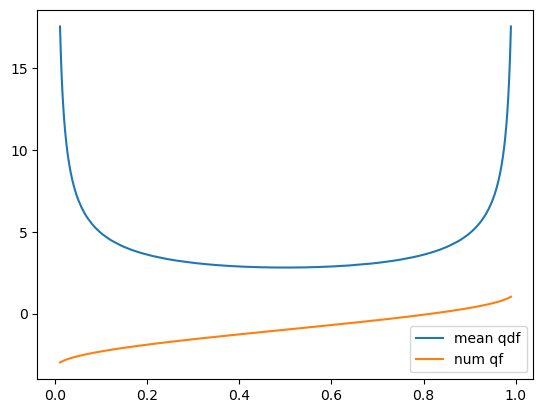

In [ ]:
mqdf = mean_qdf #np.mean(tempi, axis=0)
fig, ax = plt.subplots()
ax.plot(grid_quantiles, mqdf, label="mean qdf")
ax.plot(grid_quantiles, grid_densities[0] + riemann_sum_arrays(grid_quantiles, array=mqdf, axis=0, cumsum=True), label="num qf")
# ax.plot(grid_quantiles, mean_qf, label="analytical qf")
plt.legend()
plt.show()

In [ ]:
def fve(k):
    """Compute explained variance."""
    return np.sum(eigenvalues[:k]) / np.sum(eigenvalues)


fve(1), fve(2)

(0.8790804571454471, 0.9855911290852558)

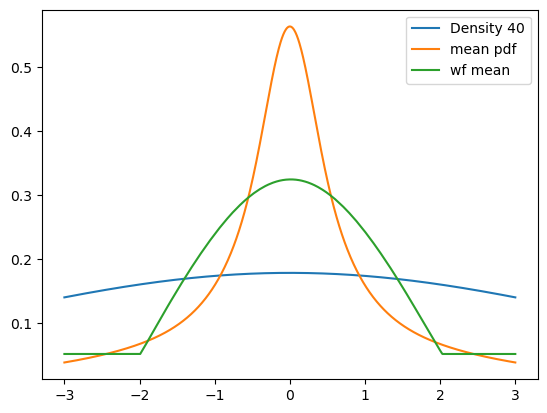

In [ ]:
fig, ax = plt.subplots()
# for i in range(3):
#     j = i + 39
#     ax.plot(grid_densities, ds_discretized[j], label=f"Density {j}")
ax.plot(grid_densities, ds_discretized[40], label=f"Density {40}")
ax.plot(grid_densities, mean_function, label="mean pdf")
ax.plot(grid_densities, f_oplus, label="wf mean")
# ax.plot(grid_quantiles, mean_qf[0] + riemann_sum_arrays(grid_quantiles, array=mean_qdf, axis=0, cumsum=True), label="qf")
plt.legend()
plt.show()